In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('GPU available',torch.cuda.is_available())


/home/seb/.cache/pypoetry/virtualenvs/kaggle-house-prices-competition-VY-Xurwb-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


System Version: 3.10.13 (main, Feb 26 2024, 19:58:12) [GCC 11.4.0]
PyTorch version 2.2.1+cu121
Torchvision version 0.17.1+cu121
Numpy version 1.25.2
Pandas version 2.2.1
GPU available True


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None) -> None:
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

    @property
    def classes(self):
        return self.data.classes


In [3]:
data_dir = '../image_dataset/train'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
dataset = PlayingCardDataset(data_dir=data_dir, transform=transform)
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [4]:
len(dataset)

7624

In [5]:
image, label = dataset[6000]
print(label)
image

41


tensor([[[0.9843, 0.9882, 0.9961,  ..., 0.9255, 0.9451, 0.9529],
         [0.9922, 0.9922, 0.9961,  ..., 0.8902, 0.9059, 0.9137],
         [1.0000, 0.9961, 0.9882,  ..., 0.8510, 0.8627, 0.8667],
         ...,
         [0.9961, 0.9922, 0.9843,  ..., 0.8784, 0.8706, 0.8667],
         [0.9922, 0.9882, 0.9922,  ..., 0.8745, 0.8667, 0.8627],
         [0.9882, 0.9882, 0.9961,  ..., 0.8745, 0.8667, 0.8627]],

        [[0.9843, 0.9882, 0.9961,  ..., 0.9255, 0.9451, 0.9529],
         [0.9922, 0.9922, 0.9961,  ..., 0.8902, 0.9098, 0.9176],
         [1.0000, 0.9961, 0.9882,  ..., 0.8549, 0.8667, 0.8706],
         ...,
         [0.9961, 0.9922, 0.9882,  ..., 0.8824, 0.8745, 0.8706],
         [0.9922, 0.9882, 0.9922,  ..., 0.8784, 0.8706, 0.8667],
         [0.9882, 0.9882, 0.9961,  ..., 0.8784, 0.8706, 0.8667]],

        [[0.9843, 0.9882, 0.9961,  ..., 0.9098, 0.9373, 0.9451],
         [0.9922, 0.9922, 0.9961,  ..., 0.8745, 0.8941, 0.9020],
         [1.0000, 0.9961, 0.9882,  ..., 0.8353, 0.8471, 0.

In [6]:
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
# iterate over dataset
for image, label in dataset:
    break


# Dataloaders
- Batching our dataset

In [8]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
for images, labels in dataloader:
    break

In [10]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [11]:
labels

tensor([ 2, 36, 29, 11, 32,  5, 16, 43, 39, 29, 35, 18, 23, 16, 12, 40, 22,  6,
         2, 13, 26, 39,  4, 23, 19, 28, 46, 17, 45, 11, 31, 34])

# Step 2. Pytorch Model

In [12]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53) -> None:
        super(SimpleCardClassifier, self).__init__()
        # Where we define all the parts of the model.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)


    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        return self.classifier(x)

In [13]:
model = SimpleCardClassifier(num_classes=53)

In [14]:
print(model)

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, ke

In [15]:
example_out = model(images)
print(example_out)
example_out.shape # [batch_size, num_classes]

tensor([[ 0.0294,  0.2682, -0.2569,  ...,  0.4684,  0.3185,  0.3512],
        [-0.3036,  0.0467,  0.3237,  ..., -0.0269,  0.1589, -0.1449],
        [ 0.1457,  0.4590,  0.1967,  ..., -0.1239, -0.3115,  0.0902],
        ...,
        [-0.0568, -0.3379, -0.1512,  ...,  0.1288, -0.0135, -0.5008],
        [-0.0531,  0.5008, -0.5241,  ...,  0.1302,  0.7677, -0.1163],
        [-0.2450, -0.1726, -0.0628,  ..., -0.2529, -0.7396,  0.3804]],
       grad_fn=<AddmmBackward0>)


torch.Size([32, 53])

# Step 3. The training loop

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
criterion(example_out, labels)

tensor(4.1283, grad_fn=<NllLossBackward0>)

In [18]:
train_folder = '../image_dataset/train'
valid_folder = '../image_dataset/valid'
test_folder = '../image_dataset/test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
num_epochs = 20
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")



Epoch 1/20 - Train loss: 1.5385412799599039, Validation loss: 0.35450546010485234
Epoch 2/20 - Train loss: 0.5662667085216279, Validation loss: 0.22333368805219542
Epoch 3/20 - Train loss: 0.3311826236006596, Validation loss: 0.12073185218954986
Epoch 4/20 - Train loss: 0.2506198439930819, Validation loss: 0.15610584054353102
Epoch 5/20 - Train loss: 0.18528945295673727, Validation loss: 0.16131126835661114
Epoch 6/20 - Train loss: 0.14249722720177577, Validation loss: 0.15179436937817986
Epoch 7/20 - Train loss: 0.13108554189674876, Validation loss: 0.09322223348437615
Epoch 8/20 - Train loss: 0.1330943169601942, Validation loss: 0.11307397102409938
Epoch 9/20 - Train loss: 0.11545712668995949, Validation loss: 0.11019276869746875
Epoch 10/20 - Train loss: 0.10387076560900413, Validation loss: 0.13857301687294582
Epoch 11/20 - Train loss: 0.07475275018888625, Validation loss: 0.0747894546052195
Epoch 12/20 - Train loss: 0.09859746937314585, Validation loss: 0.16060527720541323
Epoch 1

# Visualize Losses

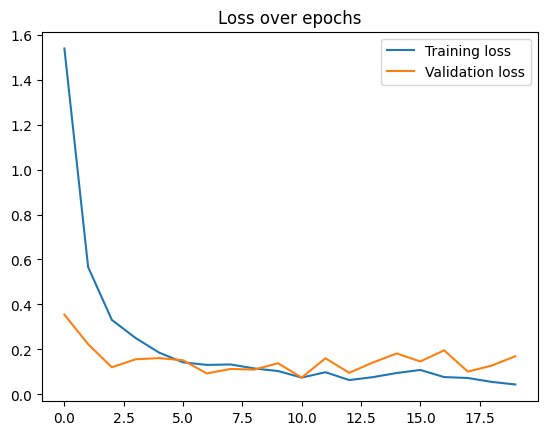

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

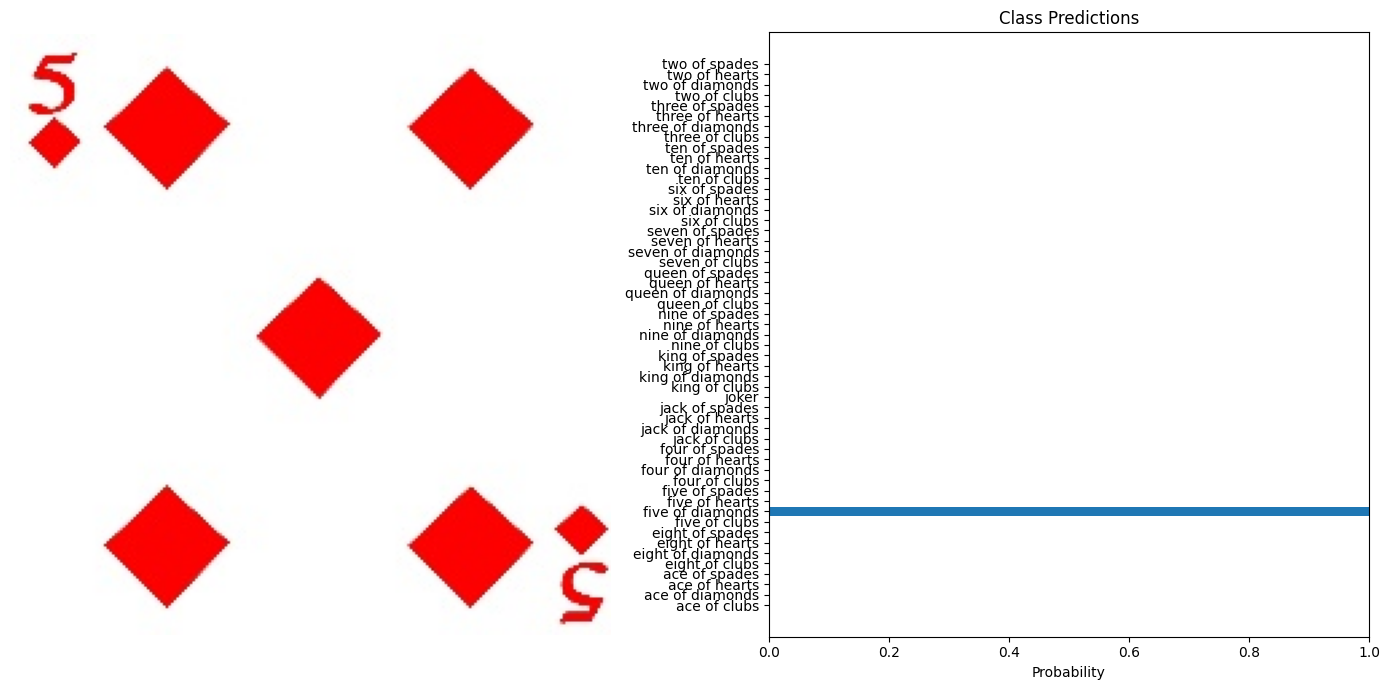

[2.5471446e-12 1.8258381e-09 3.9553308e-10 1.2540054e-13 4.7793751e-13
 1.0487147e-09 1.5150291e-11 1.5031244e-11 1.4601517e-08 9.9997389e-01
 3.9178283e-07 2.4298226e-05 1.2320946e-12 5.9980250e-11 1.8614197e-13
 7.5860908e-11 1.0595426e-11 2.0719196e-07 4.9050812e-11 3.9499497e-09
 1.4656981e-09 6.0663724e-13 3.5473735e-11 7.6980878e-12 7.7688299e-12
 4.7024873e-13 5.5806373e-09 7.3544789e-13 1.6109546e-10 2.9332206e-13
 2.3266763e-08 3.5651655e-11 1.9921101e-11 7.6688950e-12 1.3708356e-08
 5.5337343e-13 3.5883879e-11 1.8583602e-11 1.2789907e-08 4.7731281e-12
 9.5161379e-12 3.9449824e-12 2.7610090e-09 4.8301380e-12 6.0096136e-11
 2.1224851e-10 1.0788284e-06 1.4796341e-11 4.1005793e-10 3.1137987e-12
 6.5681860e-10 2.4359624e-14 1.5789831e-13]
9


In [21]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "../image_dataset/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)
print(np.argmax(probabilities, axis = 0))

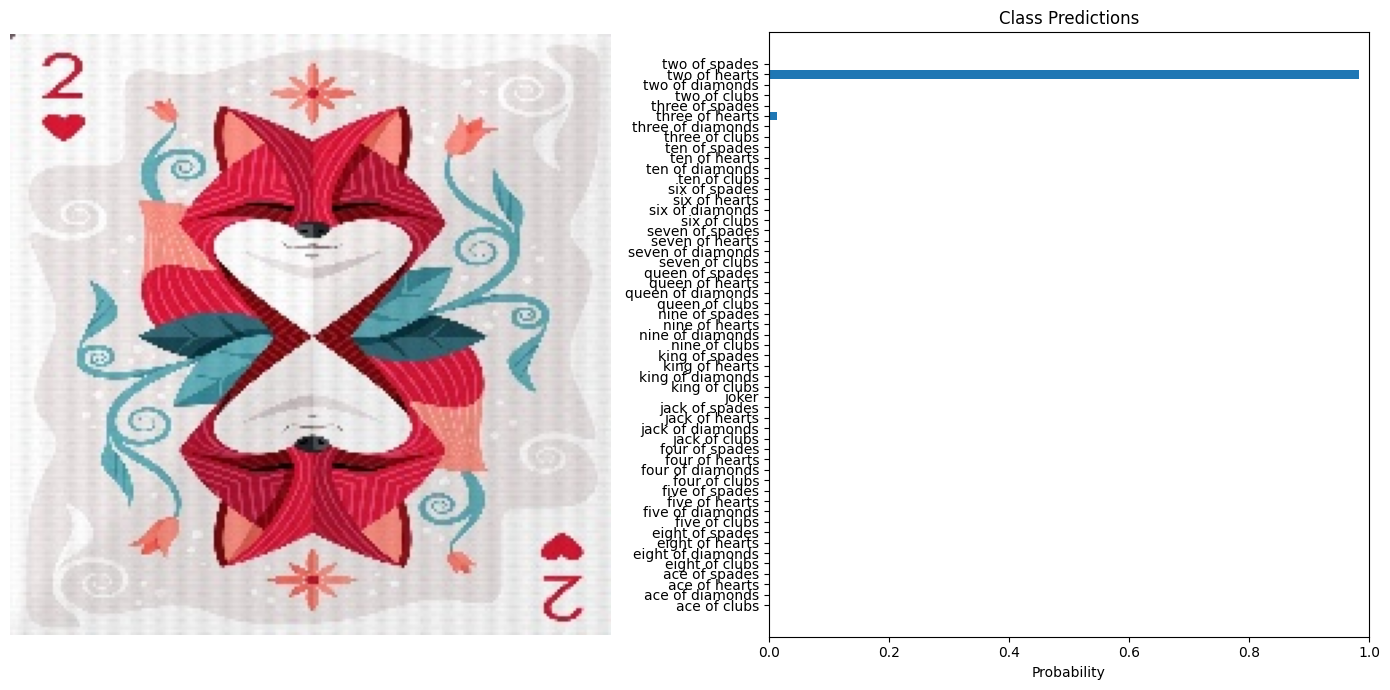

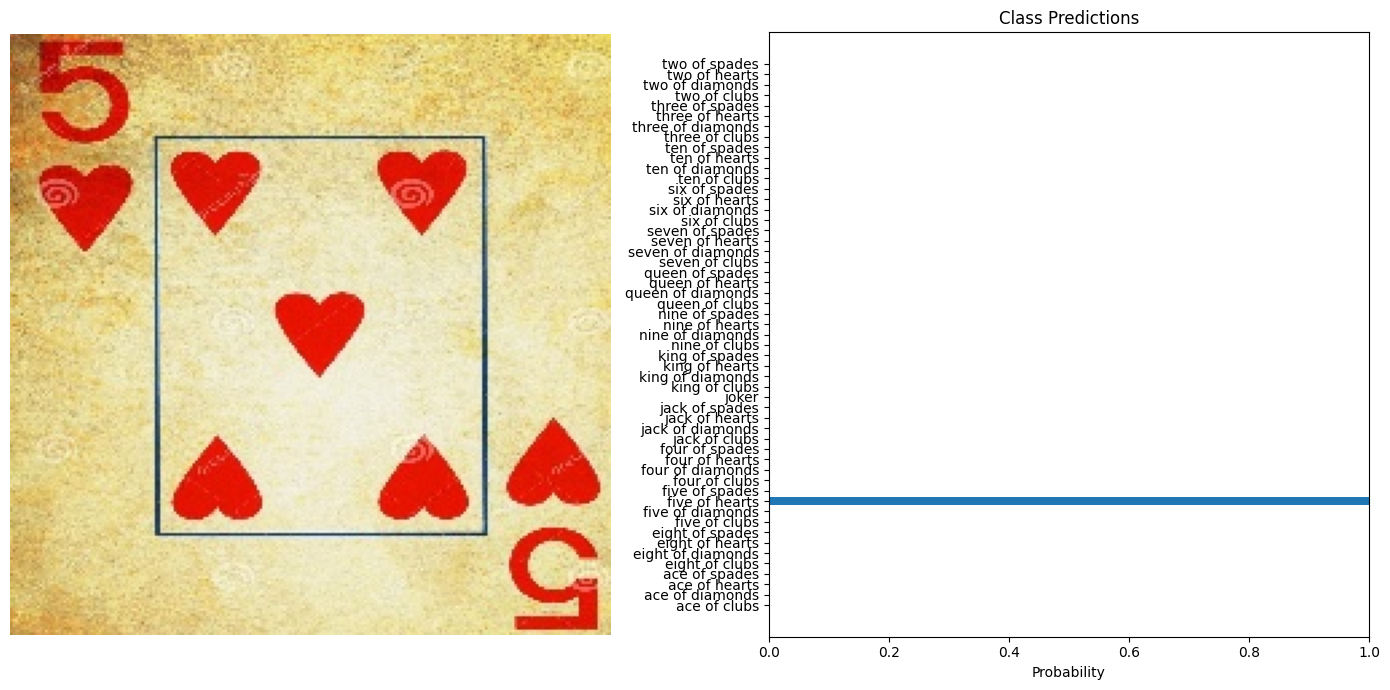

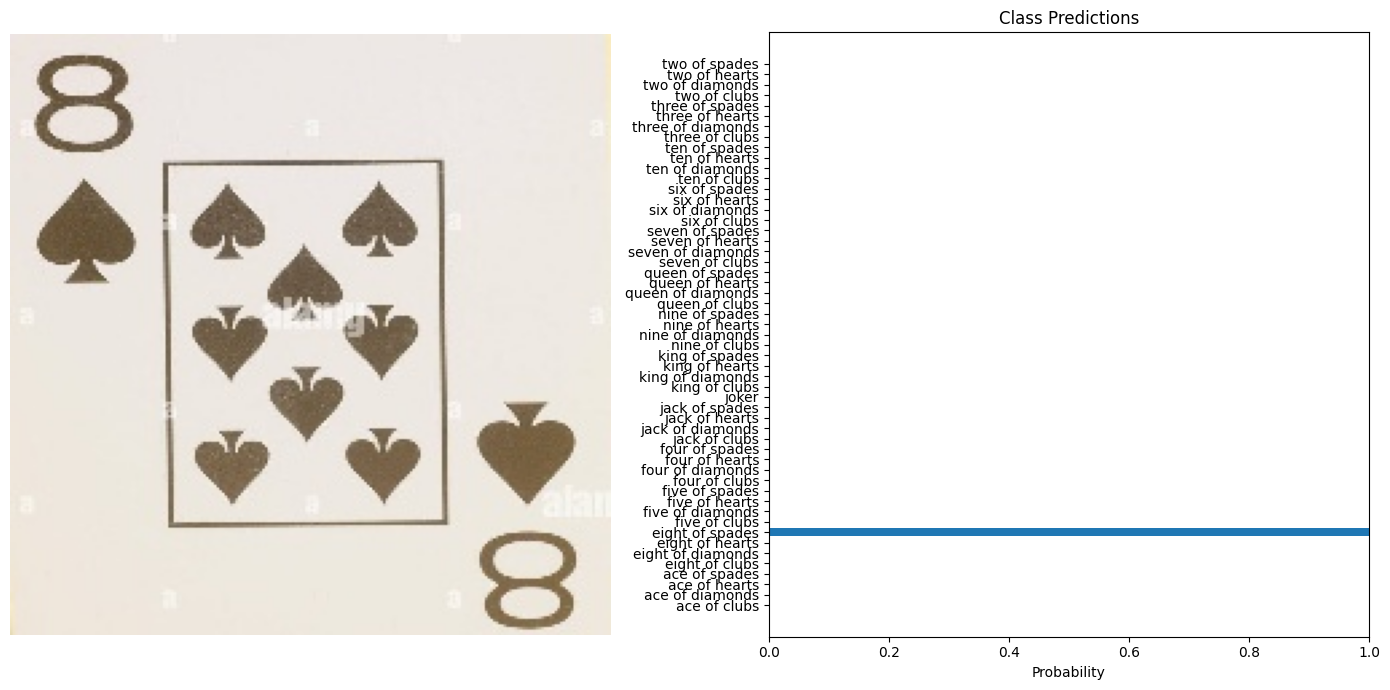

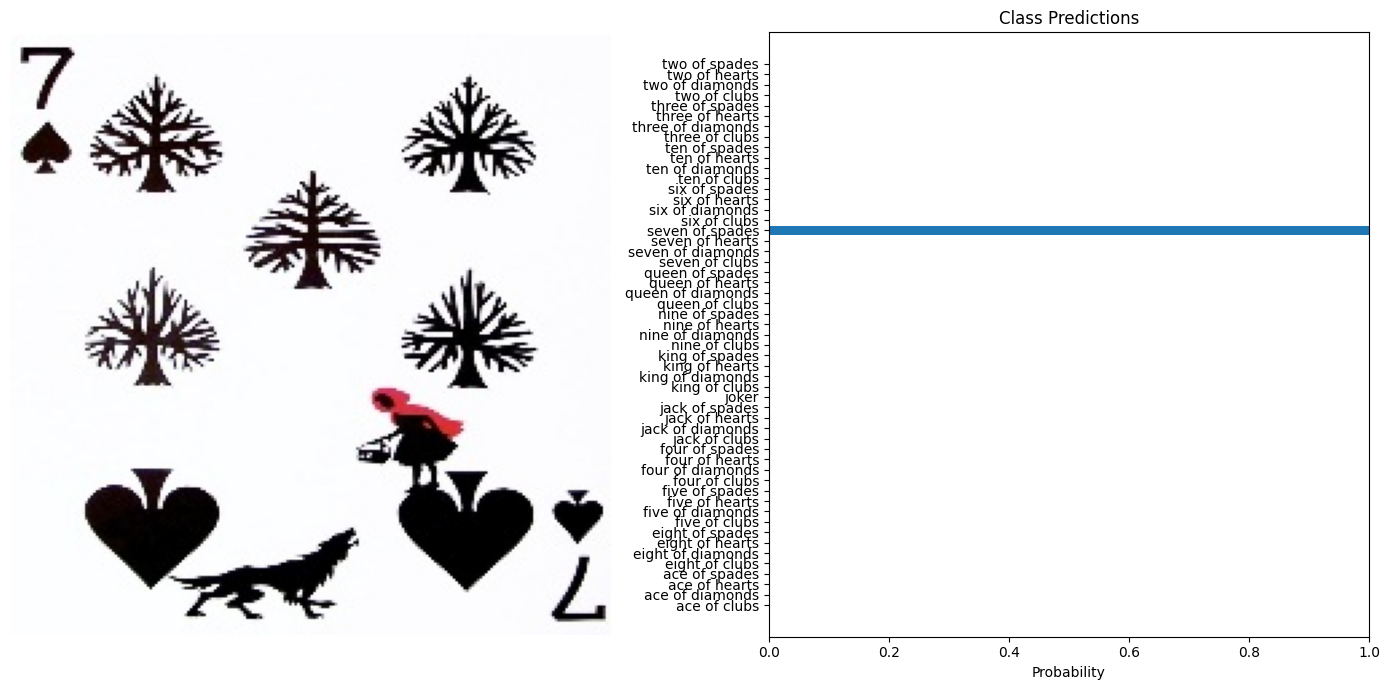

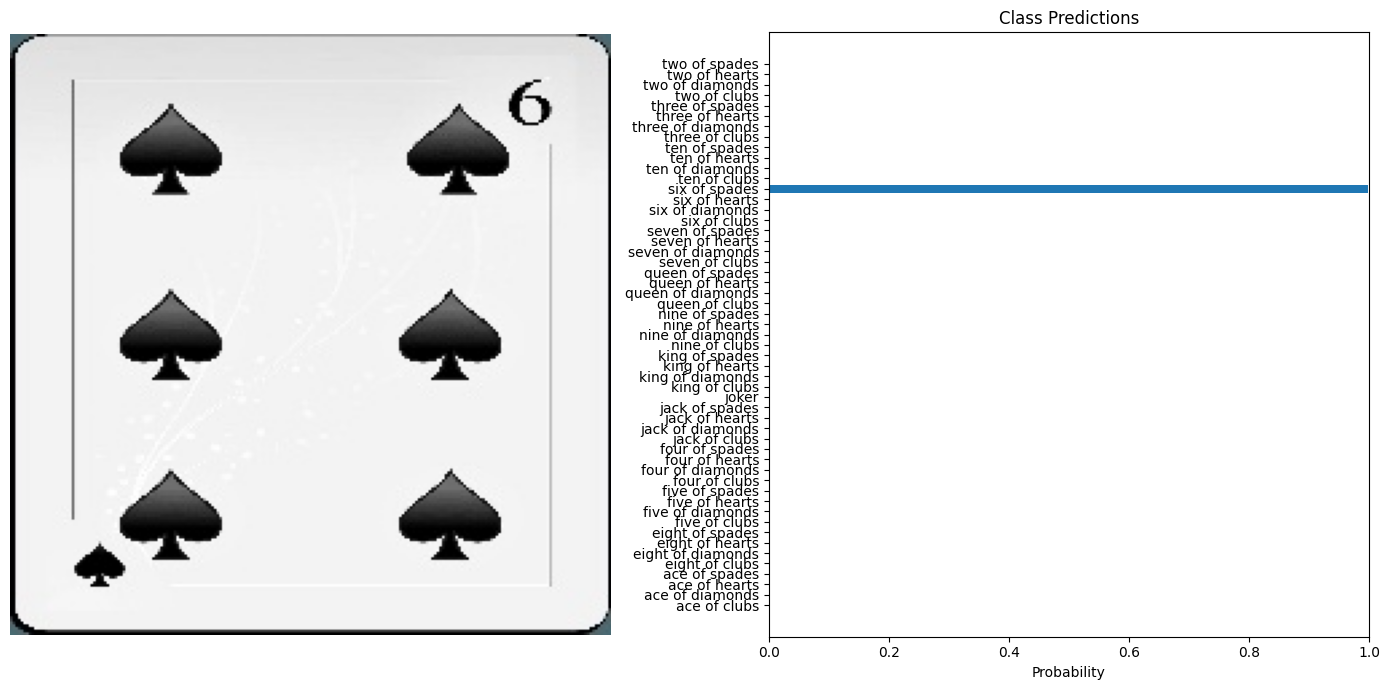

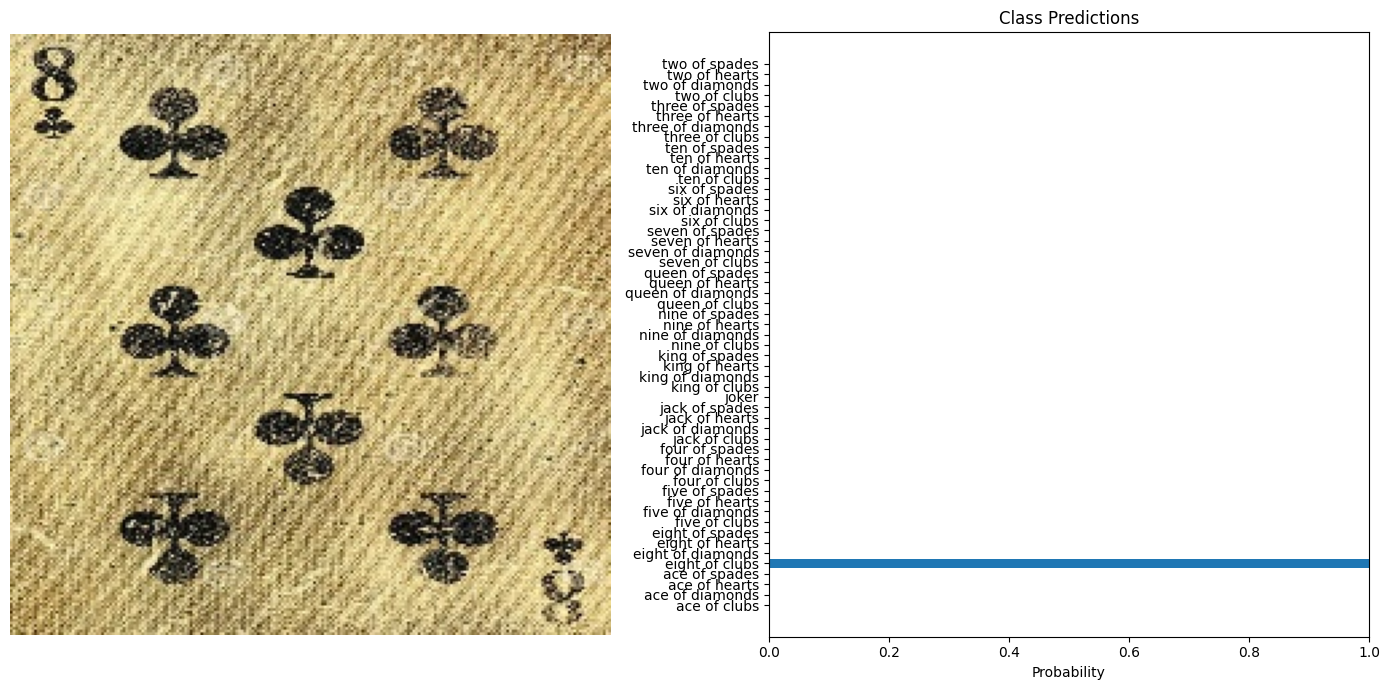

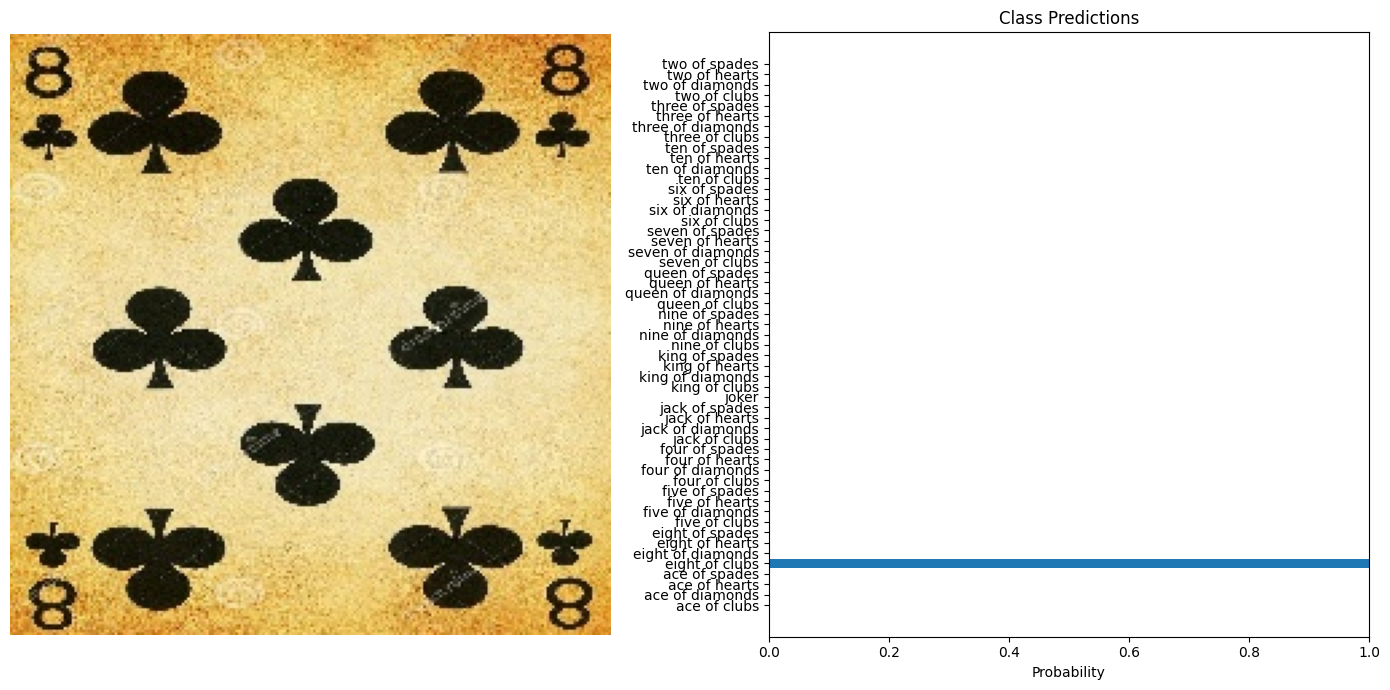

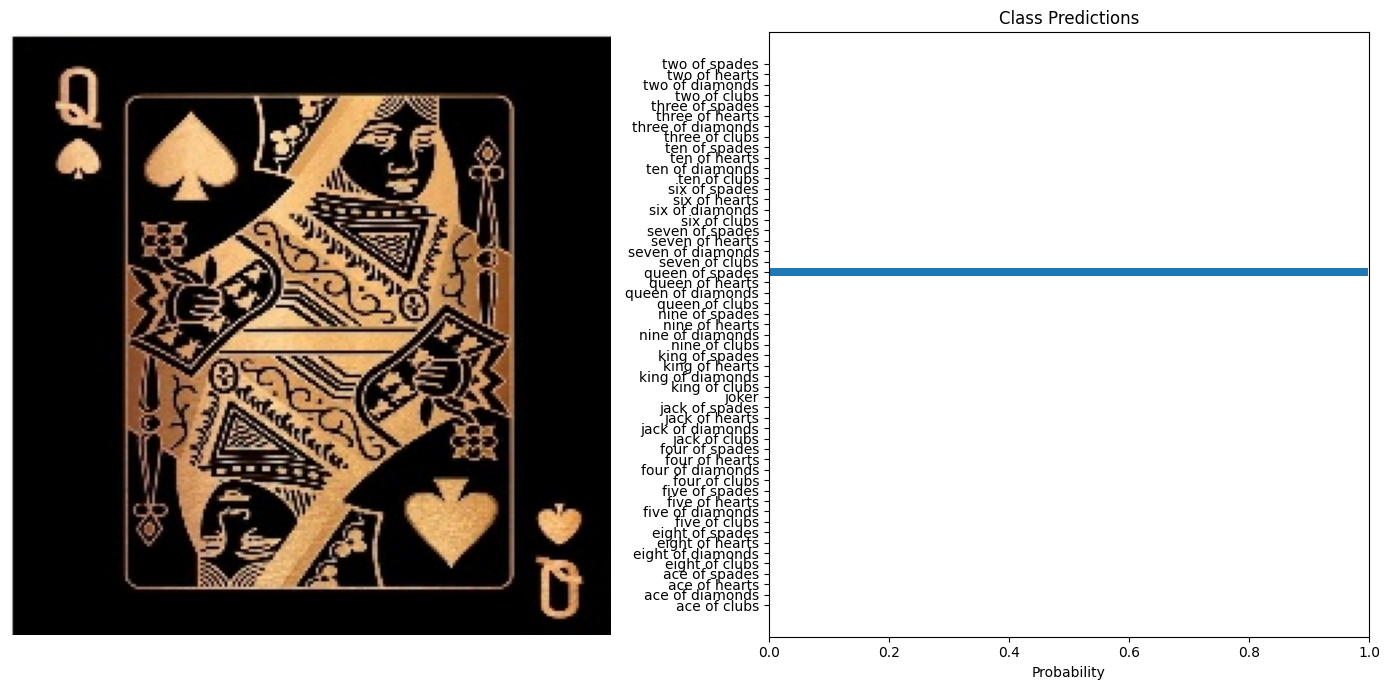

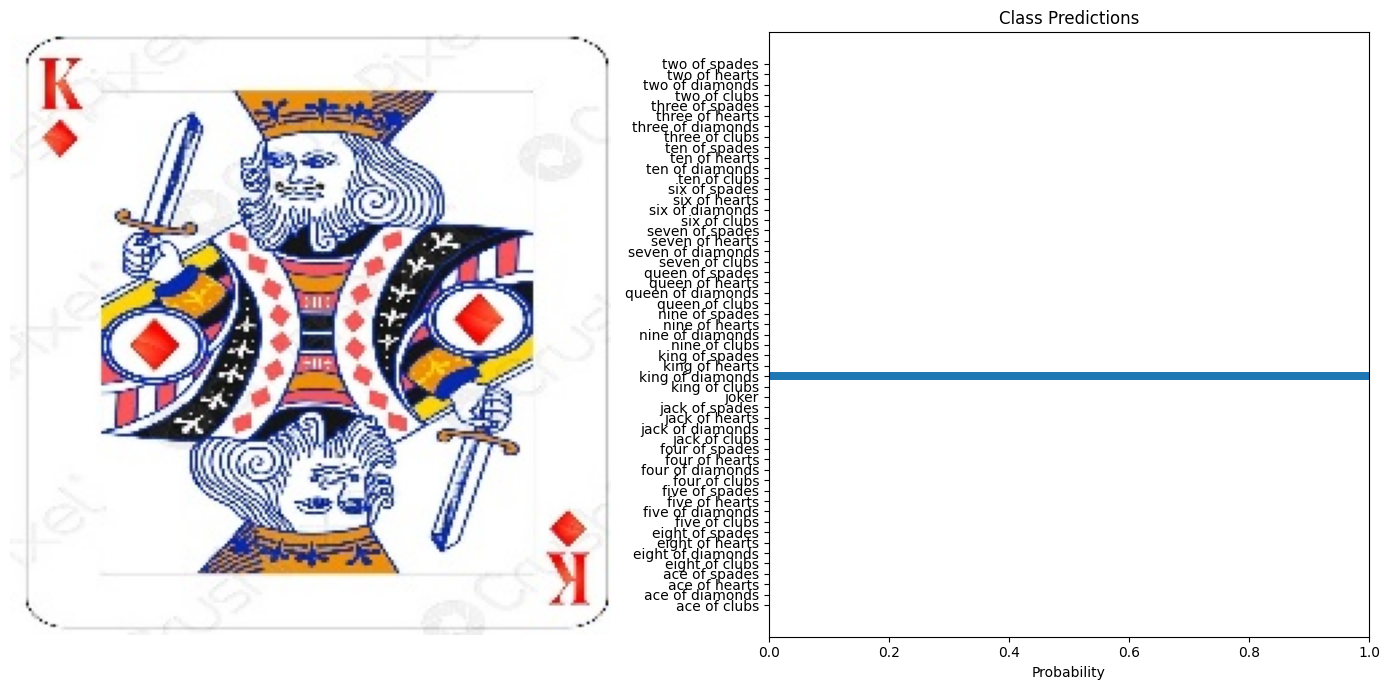

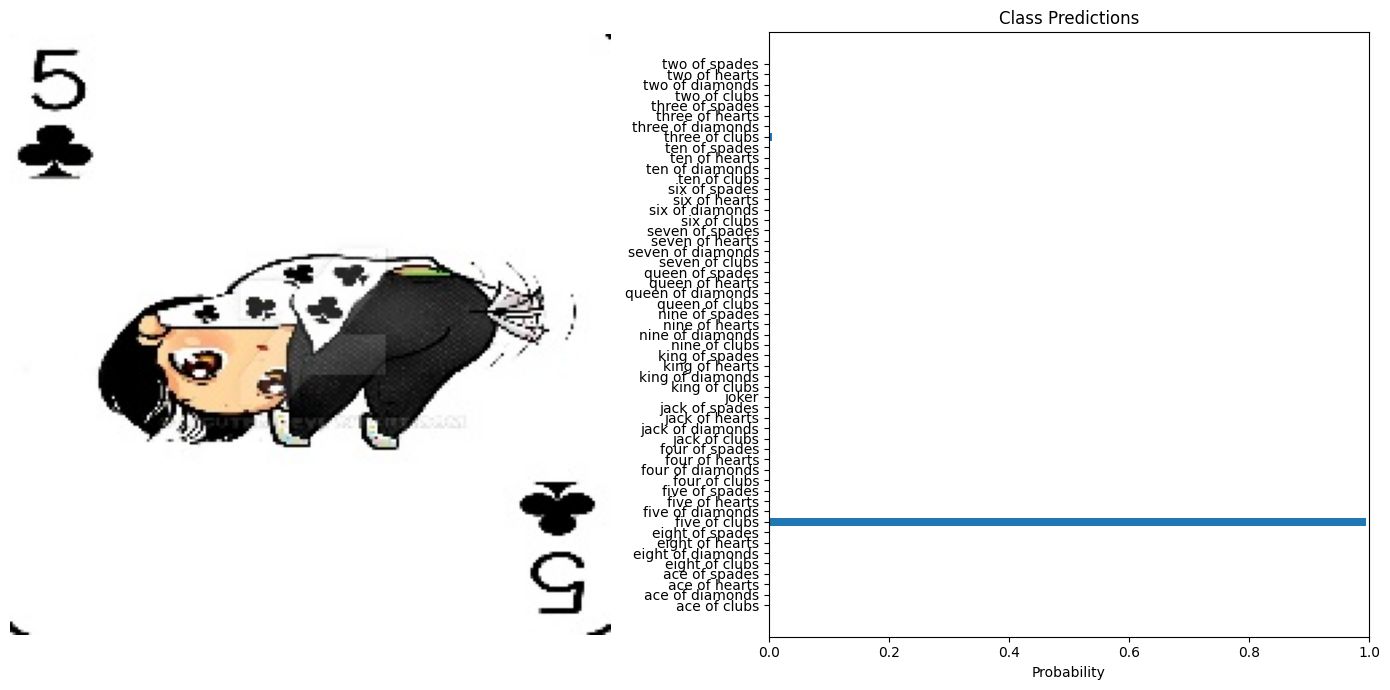

In [22]:
from glob import glob
test_images = glob('../image_dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_true = []
y_pred = []

def batch_predict(model, images, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probabilities = nn.functional.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
 
    return predictions.cpu().numpy().flatten()

for images, labels in test_loader:
    predictions = batch_predict(model, images, device)
    y_true.extend(list(labels.cpu().numpy().flatten()))
    y_pred.extend(list(predictions))

# confusion_matrix(y_true, y_pred)
accuracy_score(y_true, y_pred)




0.9849056603773585